In [1]:
from floorplan import Box, Net, FloorPlan

import cvxpy as cp
from cvxpy import Variable, Constant, Minimize, Problem
import placedb
import pylab
import math

import joblib

from sklearn.manifold import SpectralEmbedding

import scipy.io as io
import scipy.sparse.csgraph as csgraph

import jax
from jax import jit, vmap, random, grad
from jax.experimental import optimizers
from jax import numpy as jnp

from functools import partial
import itertools

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

import datetime
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [2]:
from ucsdpcb import PcbDB

In [3]:
!ls PCBBenchmarks/

bm1   bm11  bm13  bm3  bm5  bm7  bm9	   README.md
bm10  bm12  bm2   bm4  bm6  bm8  namer.py


In [4]:
numCores = joblib.cpu_count()

bm = 9 # which benchmark to load
design = "bm{}".format(bm)
pcb_path = "PCBBenchmarks/bm{}/bm{}.routed.kicad_pcb".format(bm,bm)
db = PcbDB.kicadPcbDataBase(pcb_path)

In [5]:
name2idx = {}
compw = []
comph = []
compx = []
compy = []
movable = []
initrot = []
initm = []
mirror = []
netss = []
offsets = []
size = []

maxx = 0
maxy = 0
minx = 99999999
miny = 99999999

constraint_threshold = 0 # distance between pairs of components to determine relative position constraints

In [6]:
sumarea = 0
# gather rotation and coordinates of components
for i in range(db.getInstancesCount()):
    inst = db.getInstance(i)
    compid = inst.getComponentId()

    angle = int(inst.getAngle())
    if inst.isLocked():
        movable.append(False)
    else:
        movable.append(True)
    if (angle == 0):
        initrot.append(False)
        initm.append(False)
    elif (angle == 90):
        initrot.append(True)
        initm.append(False)
    elif (angle == 180):
        initrot.append(False)
        initm.append(True)
    elif (angle == 270):
        initrot.append(True)
        initm.append(True)
        
    compx.append(inst.getX() - 0.5 * ((1-int(initrot[-1]))*db.getCompBBoxW(compid) + 
                                      (int(initrot[-1]))*db.getCompBBoxH(compid)))
    compy.append(inst.getY() - 0.5 * ((1-int(initrot[-1]))*db.getCompBBoxH(compid) + 
                                      (int(initrot[-1]))*db.getCompBBoxW(compid)))
    compw.append(db.getCompBBoxW(compid))
    comph.append(db.getCompBBoxH(compid))
    
    if compx[-1] < minx:
        minx = compx[-1]
    if compy[-1] < miny:
        miny = compy[-1]
        
    if True:
        if compx[-1] + comph[-1] > maxx:
            maxx = compx[-1] + comph[-1]
        if compy[-1] + compw[-1] > maxy:
            maxy = compy[-1] + compw[-1]
    else:
        if compx[-1] + compw[-1] > maxx:
            maxx = compx[-1] + compw[-1]
        if compy[-1] + comph[-1] > maxy:
            maxy = compy[-1] + comph[-1]
    
    print(i,inst.getX(), inst.getY(), initrot[-1], db.getCompBBoxW(compid), db.getCompBBoxH(compid), 
          angle, not inst.isLocked())
    sumarea += db.getCompBBoxW(compid)* db.getCompBBoxH(compid)
print("util: {}".format(sumarea/((maxx-minx)*(maxy-miny))))
print('num nodes: {} ({} movable)'.format(len(compx), len([m for m in movable if m])))

0 149.606 100.8634 True 4.04 2.06 270 True
1 151.8666 100.8634 True 4.04 2.06 270 True
2 140.5636 105.2322 True 4.04 2.06 90 True
3 142.7988 100.6856 False 4.04 2.06 180 True
4 145.0594 105.2068 True 6.2 6.2 270 True
5 149.479 108.6104 True 4.2 2.2 270 True
6 151.7396 108.585 True 4.2 2.2 270 True
7 156.083 104.902 True 10.2 3.7 90 False
util: 0.5859955650013281
num nodes: 8 (7 movable)


In [7]:
"""Gather pin offset information """
for i in range(db.getNumNets()):
    net = db.getNet(i)
    pins = net.getPins()
    netss.append([])
    offsets.append([])
    for p in pins:
        instid = p.getInstId()
        netss[-1].append(instid)
        px = db.getPinPositionX(p)
        py = db.getPinPositionY(p)
        inst = db.getInstance(instid)
        ix = inst.getX() 
        iy = inst.getY()
        w = comph[instid]
        h = compw[instid]

        angle = int(inst.getAngle())

        xoff = (1-int(initrot[instid]))*(px-ix)/h + (int(initrot[instid]))*(px-ix)/w
        yoff = (1-int(initrot[instid]))*(py-iy)/w + (int(initrot[instid]))*(py-iy)/h
        assert np.abs(xoff) < 1.0
        assert np.abs(yoff) < 1.0
        if True:
            t = xoff
            xoff = yoff
            yoff = t

        if (angle == 0):##
            offsets[-1].append((xoff,yoff))
        elif (angle == 90):##
            offsets[-1].append((yoff,xoff))
        elif (angle == 180):##
            offsets[-1].append((xoff,yoff))
        elif (angle == 270):##
            offsets[-1].append((yoff,xoff))
        else:
            assert False
            
offsets = [o for o, n in zip(offsets, netss) if len(n)>=2]        
netss = [n for n in netss if len(n)>= 2]
netlens = [len(n) for n in netss]
maxlenidx = np.array(netlens).argsort()[-2:]

offsets = [o for i,o in enumerate(offsets) if i not in maxlenidx]
netss = [n for i,n in enumerate(netss) if i not in maxlenidx]

In [8]:
"""Instantiate MILP variables """
nets = []
for i, net in enumerate(netss):
    nodes = net
    pin_offsets = offsets[i]
    
    # ignore 1-pin nets
    if len(nodes) <=1: continue
    nets.append(Net(nodes, pin_offsets, i))
    
boxes = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=movable[i], pl=movable[i], m=False))

    placeable_area = (56,52)

num_nets = len(netss)
num_nodes = len(boxes)
adj=np.zeros((num_nodes,num_nodes))
for netid, net in enumerate(netss):
    for nodeid1 in net:
        for nodeid2 in net:
            adj[nodeid1,nodeid2] += 1
  
# order constraints
vo = []
ho = []

norelpairs = []

for i1, x1 in enumerate(zip(compx, compy)):
    for i2, x2 in enumerate(zip(compx, compy)):
        if i2 <= i1:
            continue
        # if distance greater than threshold
        if max(abs(x1[0] - x2[0]), abs(x1[1] - x2[1])) > constraint_threshold:
            if abs(x1[0] - x2[0]) < abs(x1[1] - x2[1]):
                if x1[1] < x2[1]:
                    vo.append([i1, i2])
                else:
                    vo.append([i2,i1])
            else:
                if x1[0] < x2[0]:
                    ho.append([i1, i2])
                else:
                    ho.append([i2,i1]) 
        else:
            norelpairs.append([i1,i2])

horiz_order = [[boxes[i] for i in h] for h in ho]
vert_order = [[boxes[i] for i in v] for v in vo]

print('num horizontal & vertical constraints:',len(horiz_order),len(vert_order))

num horizontal & vertical constraints: 20 8


Compiled constraints
39.239199934084354


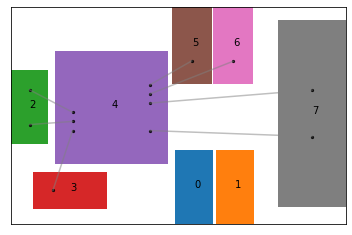

In [9]:
# First, just plot the manual layout (set all components to not be movable / rotateable / no constraints)
boxes = []
horiz_order = []
vert_order = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=False, pl=False, m=False))
    
fp = FloorPlan(boxes, nets,adj,obj=False,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
               max_seconds=3800, num_cores=numCores-1, name=design)
p, c = fp.layout()
print(fp.h.value)
fp.show()

num horizontal & vertical constraints: 5 2
Compiled constraints
29.976999921813714


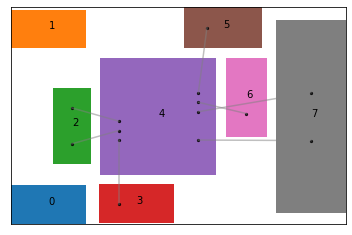

In [11]:
# Now, try making the movable components movable, but not rotateable (to save some time), 
# and impose constraints on just the fixed nodes:

# order constraints
vo = []
ho = []

norelpairs = []

for i1, x1 in enumerate(zip(compx, compy)):
    for i2, x2 in enumerate(zip(compx, compy)):
        if i2 <= i1:
            continue
        # one of the two is a fixed node
        if ((not movable[i1]) or (not movable[i2])):
            if abs(x1[0] - x2[0]) < abs(x1[1] - x2[1]):
                if x1[1] < x2[1]:
                    vo.append([i1, i2])
                else:
                    vo.append([i2,i1])
            else:
                if x1[0] < x2[0]:
                    ho.append([i1, i2])
                else:
                    ho.append([i2,i1]) 
        else:
            norelpairs.append([i1,i2])

horiz_order = [[boxes[i] for i in h] for h in ho]
vert_order = [[boxes[i] for i in v] for v in vo]
print('num horizontal & vertical constraints:',len(horiz_order),len(vert_order))

boxes = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=movable[i], pl=movable[i], m=False))
    
fp = FloorPlan(boxes, nets,adj,obj=True,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
               max_seconds=3800, num_cores=numCores-1, name=design)
p, c = fp.layout()
print(fp.h.value)
fp.show()

In [ ]:
"""write back to db """
for i in range(db.getInstancesCount()):
    inst = db.getInstance(i)
    compid = inst.getComponentId()
    
    box = fp.boxes[i]
    
    xpos = box.x.value.item() + 0.5 * ((1-fp.boxes[i].r.value)*fp.boxes[i].w.value + 
                                          (fp.boxes[i].r.value)*fp.boxes[i].h.value)
    ypos = box.y.value.item()+ 0.5 * ((1-fp.boxes[i].r.value)*fp.boxes[i].h.value + 
                                         (fp.boxes[i].r.value)*fp.boxes[i].w.value)
    inst.setX(xpos)
    inst.setY(ypos)

    rotated = box.r.value
    mirroredX = box.mx.value.item()
    mirroredY = box.my.value.item()
    
    init_angle = inst.getAngle()
 
    print(i, xpos, ypos, box.w, box.h,init_angle, rotated)

    if (init_angle==0) and (rotated == 0.0):
        inst.setAngle(90)
    elif (init_angle==0) and (rotated == 1.0):
        inst.setAngle(0)
    elif (init_angle==90) and (rotated == 0.0):
        inst.setAngle(90)
    elif (init_angle==90) and (rotated == 1.0):
        inst.setAngle(180)
    elif (init_angle==180) and (rotated == 0.0):
        inst.setAngle(270)
    elif (init_angle==180) and (rotated == 1.0):
        inst.setAngle(180)
    elif (init_angle==270) and (rotated == 0.0):
        inst.setAngle(270)
    elif (init_angle==270) and (rotated == 1.0):
        inst.setAngle(0)
    print(i, xpos, ypos, box.w, box.h,inst.getAngle(), rotated)    
    

In [ ]:
"""print db to file """
db.printKiCad()